# The Spark Foundation : GRIP

## Author : Mohamed Gamal

## Task 7

### Stock Market Prediction using Numerical and Textual Analysis 

**Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines**

**Stock to analyze and predict - SENSEX (S&P BSE SENSEX)**

In [1]:
# Importing the libraries
import os                                                                  #for read & manipulate files
import pandas as pd                                                        #for read & manipulate dataset
import numpy as np                                                         #for fast operations on arrays
import seaborn as sns                                                      #for Data visualization
import matplotlib.pyplot as plt                                            #for Data visualization

import warnings
warnings.filterwarnings('ignore')

import nltk                                                                 #NLP analysis
nltk.downloader.download('vader_lexicon')                                   #NLP analysis
import re                                                                   #NLP analysis
from textblob import TextBlob                                               #NLP analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer                 #NLP analysis
from sklearn.preprocessing import MinMaxScaler                              #Normalization

from sklearn.metrics import mean_squared_error                              #Evaluation Model Performance
from sklearn.model_selection import train_test_split                        #split dataset
import xgboost                                                              #Model


[nltk_data] Downloading package vader_lexicon to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the first dataset
columns=['Date','Category','News']
dataset_news = pd.read_csv("india-news-headlines.csv",names=columns)
dataset_news.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


**it contains date of publishing and news headline and category**

In [3]:
#**lets drop category column no need it in our work and create a copy from dataset**
dataset_news.drop(0, inplace=True)
dataset_news.drop('Category', axis = 1, inplace=True)
df_news = dataset_news.copy()
df_news.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


In [4]:
# Load the second dataset
dataset_price = pd.read_csv("AAPL.csv")
df_price = dataset_price.copy()
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200


### Preprocessing

In [5]:
#modify date format in 2 dataset
df_news["Date"] = pd.to_datetime(df_news["Date"],format='%Y%m%d')
df_price["Date"]= pd.to_datetime(df_price["Date"])

#removing unwanted characters from the News
df_news.replace("[^a-zA-Z']"," ",regex=True,inplace=True)

In [6]:
df_news.head(2)

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya s...
2,2001-01-02,Fissures in Hurriyat over Pak visit


In [7]:
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600


In [8]:
# Group the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace=True,drop=True)

In [9]:
df_news.head(3)

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...


### EDA News

In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7262 non-null   datetime64[ns]
 1   News    7262 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 113.6+ KB


In [11]:
df_news.describe()

,Date,News
count,7262,7262
unique,7262,7262
top,2001-01-02 00:00:00,Status quo will not be disturbed at Ayodhya s...
freq,1,1
first,2001-01-02 00:00:00,NaN
last,2020-12-31 00:00:00,NaN


In [12]:
print("Nimber of rows : {}".format(df_news.shape[0]))

Nimber of rows : 7262


In [13]:
#Check Missing Values
def check_missing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

check_missing(df_news)

,Total,Percent
Date,0,0.0
News,0,0.0


### EDA Prices

In [14]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2530 non-null   datetime64[ns]
 1   Open       2530 non-null   float64       
 2   High       2530 non-null   float64       
 3   Low        2530 non-null   float64       
 4   Close      2530 non-null   float64       
 5   Adj Close  2530 non-null   float64       
 6   Volume     2530 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 138.5 KB


In [15]:
df_price.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2.530000e+03
mean,3.063437,3.104524,3.015976,3.062200,2.625424,6.318549e+08
std,3.028080,3.058057,2.989976,3.026523,2.594836,4.267660e+08
min,0.231964,0.235536,0.227143,0.234286,0.200869,3.934000e+07
25%,0.409107,0.417098,0.401116,0.409955,0.351481,3.226076e+08
50%,2.202857,2.223215,2.172500,2.200000,1.886203,5.187196e+08
75%,4.941696,4.987054,4.856518,4.915714,4.214562,8.195264e+08
max,12.441071,12.450000,12.301429,12.445714,10.670522,3.372970e+09


In [16]:
print("Nimber of rows : {}".format(df_price.shape[0]))

Nimber of rows : 2530


In [17]:
check_missing(df_price)

,Total,Percent
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Adj Close,0,0.0
Volume,0,0.0


Text(0, 0.5, 'APPL')

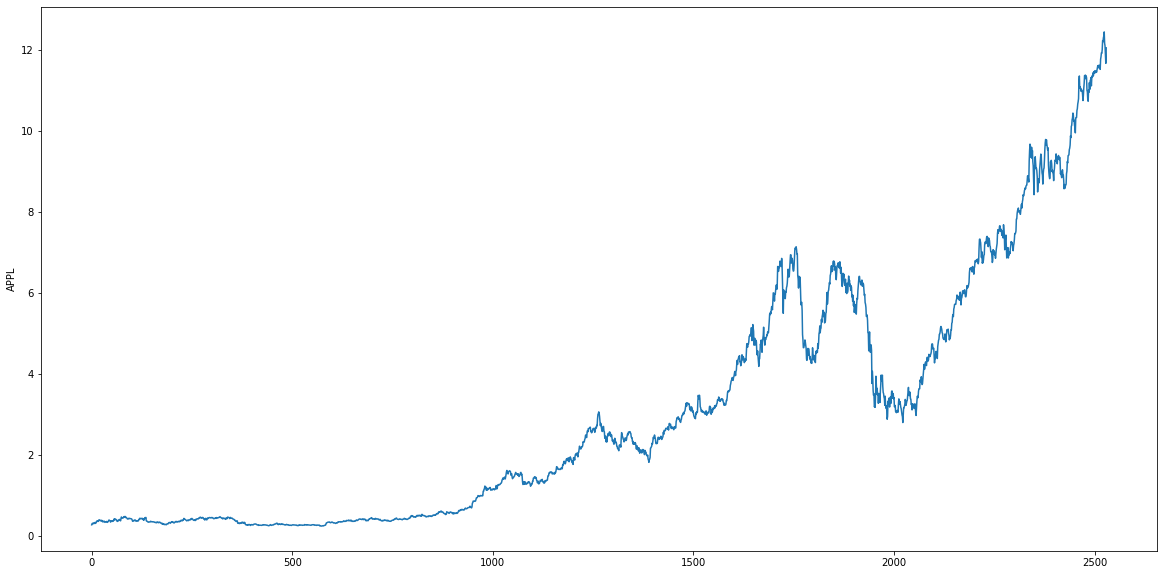

In [18]:
# Figure plot
plt.figure(figsize=(20,10))
df_price['Close'].plot()
plt.ylabel('APPL')

### Analysis Textual

In [19]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
      return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
      return  TextBlob(text).sentiment.polarity

In [20]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [21]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()
df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.132,0.787,0.082
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.143,0.758,0.098
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.154,0.748,0.098
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.150,0.764,0.086


### Combining the Prices and Textual Data

In [22]:
df_merge = pd.merge(df_price, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200,Sangh Parivar Babri panel up the ante Frontru...,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,2011-01-18,11.768571,12.312857,11.642857,12.166071,10.430767,1880998000,Top sex mistakes men make No alcohol for pac...,0.356768,0.052758,-0.9999,0.143,0.776,0.081
2498,2011-01-19,12.441071,12.450000,12.031429,12.101429,10.375341,1135612800,My ex doesn't want me Pratik Saali is not a g...,0.357963,0.066948,-0.9998,0.140,0.770,0.089
2499,2011-01-20,12.015357,12.082143,11.790000,11.881429,10.186724,764789200,Neetu Chandra denies going panty less Aishwar...,0.358613,0.047965,-0.9999,0.164,0.737,0.098
2500,2011-01-21,11.920357,11.960000,11.665357,11.668571,10.004225,754401200,Giving the kids a dressing up AK Hangal's ill ...,0.398969,0.030309,-0.9999,0.168,0.734,0.098


In [23]:
df_final = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
df_final

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.265625,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,0.292411,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,0.304688,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,0.292411,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,0.295759,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...
2497,12.166071,0.356768,0.052758,-0.9999,0.143,0.776,0.081
2498,12.101429,0.357963,0.066948,-0.9998,0.140,0.770,0.089
2499,11.881429,0.358613,0.047965,-0.9999,0.164,0.737,0.098
2500,11.668571,0.398969,0.030309,-0.9999,0.168,0.734,0.098


### Normalization

In [24]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_final))
df_scaled.columns = df_final.columns
df_scaled.index = df_final.index
df_scaled.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.002566,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.004760,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.005765,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.004760,0.480553,0.678214,0.982299,0.319820,0.694,0.269737
4,0.005034,0.400343,0.302819,0.011051,0.272523,0.813,0.108553


### Split Dataset to input and output

In [26]:
X=df_scaled.drop('Close',axis=1)
y=df_scaled['Close']

### Split Train & Test Data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

### XGBRegressor Model

In [33]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)

### XGBRegressor Model Performance

In [43]:
print(mean_squared_error(y_test,predictions))

0.04826024674534945


**A perfect mean squared error value is 0.0, which means that all predictions matched the expected values exactly.**

**We observe that Xgboost model performs the best for the sentiment analysis**